# Problem B: Effective thermal conductivity of 2-phase materials
Predicting the effective thermal conductivity $k_{\text{eff}}$ of a two-phase composite material is a classical and practical problem in materials science. The goal is to estimate the bulk conductivity of a heterogeneous material made of two constituents with thermal conductivities $k_1$ and $k_2$. One efficient way to compute the effective thermal conductivity of given 2-phase materials is through numerical homogenization.

In numerical homogenization, we need to solve the steady-state heat equation on a representative volume element (RVE): 
$$
-\nabla\cdot(k(x,y)\nabla T) = 0,\quad (x,y)\in\Omega=[0,1]^2 \tag{2}
$$
With the following boundary conditions:
  - $T(x=0,y)=0,\ T(x=1,y)=1 $
  - $\frac{\partial T}{\partial \vec{n}}(x,y=0)=\frac{\partial T}{\partial \vec{n}}(x,y=1)=0$

where $T(x,y)$ indicates the temperature  and $k(x,y)$ indicates thermal conductivity, which is defined piecewise:
$$
k(x,y)=
\begin{cases}
k_1=2.,\quad (x,y)\in\Omega_1\\
k_2=10.,\quad (x,y)\in\Omega_2
\end{cases}
$$
where $\Omega_1$, $\Omega_2$ denote the first phase region and the second phase region, respectively.

<!-- To compute the effective thermal conductivity in the $x$-direction, one can follow the steps:
- **Step 1:** Solve the following PDE:
    $$
    -\nabla\cdot(k(x,y)\nabla T) = 0,\quad (x,y)\in\Omega=[0,1]^2 \tag{3}
    $$
  With boundary conditions:
  - $T(x=0,y)=0,\ T(x=1,y)=1 $
  - $\frac{\partial T}{\partial \vec{n}}(x,y=0)=\frac{\partial T}{\partial \vec{n}}(x,y=1)=0$ 
- **Step 2:** Compute the **average heat flux:**
    $$
    <q> = \frac{1}{|\Omega|}\int_{\Omega}q~d\Omega
    $$
  where $q(x,y)=-k(x,y)\partial_x T$, and the **average temperature gradient:**
    $$
    <\partial_x T> =  \frac{1}{|\Omega|}\int_{\Omega}\partial_x T~d\Omega
    $$
- **Step 3:** Compute the **effective thermal conductivity (in $x$-direction):**
    $$
    k_{eff} = -\frac{<q>}{<\partial_x T>} = \frac{<k(x,y)\partial_x T>}{<\partial_x T>}
    $$ -->

## Task: predicting the temperature field $T(x,y)$ given 2-phase material $k(x,y)$ 
In this task, we have collected many materials $k(x,y)$ which are sampled from a distribution $\mathcal{A}$. We have also computed the corresponding temperature field $T(x,y)$ through solving the PDE problem $(2)$ with high-precision FEM method. Now, we hope to make a fast prediction of the temperature field $T(x,y)$ (therefore, a fast prediction of the effective conductivity) of a group of materials that are sampled from the same distribution.

### The goals
- Please select a suitable deep learning method for solving this task, and explain the reason for using it
- Report your setups for the implementation, such as network structure, activation function, optimizer (with learning rate), epoch (with batch size), loss weights, and other tricks that are used for improvement.
- Compute the $L^2$ relative error (on testing dataset) at each training epoch and plot the ```Error vs. epcoh``` curve (and report the final error). The $L^2$ relative error between the prediction $\{T^{(j)}_{pred}\}^{N}_{j}$ and the truth $\{T^{(j)}_{true}\}^{N}_j$ is defined as follows:
  $$error = \frac{1}{N}\sum_j\sqrt{\frac{\sum_i|T^{(j)}_{pred}(x_i)-T^{(j)}_{true}(x_i)|^2}{\sum_i|T^{(j)}_{true}(x_i)|^2}}$$
 where $j$ indicates the $j$-th instance.
- Plot the material thermal conductivity, the corresponding predicted solution (and the ground truth reference), and the pointwise absolute error for the first instance in the testing Dataset using separate figures with ```matplotlib```.

### Dataset
The observation and the ground truth references are given in the dataset ```EffectiveConductivity.h5```:
- ```k_train```: size(1000, 36, 36), the collected materials (a $36\times 36$ matrix represents each material)
- ```T_train```: size(1000, 36, 36), the collected temperature field (computed on a $36\times 36$ regular mesh)
- ```k_test```: the materials that we are going to predict their corresponding temperature field (Should not be used for training)
- ```T_test```: the ground truth reference of the temperature field (Should not be used for training)
- ```X```: size(36, 36), the $x$-coordiante of locations where the temperature field computed
- ```Y```: size(36, 36), the $y$-coordiante of locations where the temperature field computed
- Link to dataset: [https://www.kaggle.com/datasets/yhzang32/dno4pdes](https://www.kaggle.com/datasets/yhzang32/dno4pdes)

<KeysViewHDF5 ['T_test', 'T_train', 'X', 'Y', 'dTx_test', 'dTx_train', 'k_test', 'k_train']>
The shape of X: torch.Size([36, 36]) The shape of Y: torch.Size([36, 36])
The shape of k_train: torch.Size([1000, 36, 36])
The shape of T_train: torch.Size([1000, 36, 36])
The shape of k_test: torch.Size([200, 36, 36])
The shape of T_test: torch.Size([200, 36, 36])


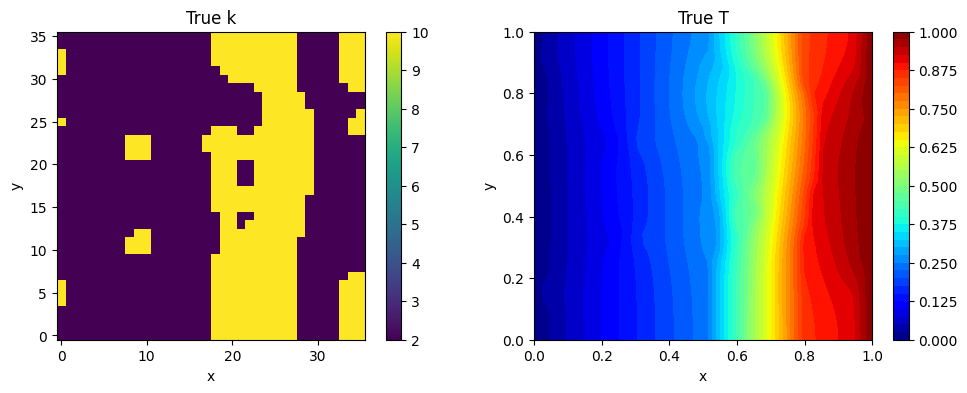

In [1]:
import numpy as np
import h5py
import torch 
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
device = 'cpu'
dtype = torch.float32
######################################
# Load training data
######################################
with h5py.File('EffectiveConductivity.h5', 'r') as data:
    print(data.keys())
    k_train = torch.tensor(np.array(data["k_train"]), dtype=dtype); k_train[k_train==0]=2.; k_train[k_train==1]=10.
    T_train = torch.tensor(np.array(data["T_train"]), dtype=dtype)
    k_test = torch.tensor(np.array(data["k_test"]), dtype=dtype); k_test[k_test==0]=2.; k_test[k_test==1]=10.
    T_test =torch.tensor( np.array(data["T_test"]), dtype=dtype)
    # The coordinates
    X = torch.tensor(np.array(data['X']), dtype=dtype)
    Y = torch.tensor(np.array(data['Y']), dtype=dtype)
print('The shape of X:', X.shape, 'The shape of Y:', Y.shape)
print('The shape of k_train:', k_train.shape)
print('The shape of T_train:', T_train.shape)
print('The shape of k_test:', k_test.shape)
print('The shape of T_test:', T_test.shape)

####### Visualize the training data 
k_show, T_show = k_train[0], T_train[0]
#
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))
#
cntr0 = axs.flat[:][0].imshow(k_show, origin='lower')
fig.colorbar(cntr0, ax=axs.flat[:][0])
axs.flat[:][0].set_title('True k')
axs.flat[:][0].set_xlabel('x')
axs.flat[:][0].set_ylabel('y')
#
cntr1 = axs.flat[:][1].contourf(X, Y, T_show, levels=40, cmap='jet')
fig.colorbar(cntr1, ax=axs.flat[:][1])
axs.flat[:][1].set_title('True T')
axs.flat[:][1].set_xlabel('x')
axs.flat[:][1].set_ylabel('y')
#
plt.show()